In [2]:
%load_ext autoreload
%autoreload 2

In order to run this notebook you need to install the Augmented Hierarchical Shrinkage package. For further instructions see the `README.md` file on GitHub.

In [3]:
# Import TreeModelsfromScratch
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import smooth_shap, GridSearchCV_scratch, cross_val_score_scratch

In [4]:
# Import other packages
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# `TreeModelfromScratch` python module

The `TreeModelfromScratch` python module includes algorithms for decision trees and random forests for classification and regression tasks, and tools for model selection, model evaluation, and other utilities.<br>
The module includes two main classes: `DecisionTree` and `RandomForest`. These classes allow instantiating “regular” versions of these tree-based models without regularization. They also come with functions to apply HS and Aug HS regularization post-hoc.<br>
This notebook includes examples on how to instantiate and train the different model versions. **Please note**, that  we only show examples for the classification model type. For regression models one simply needs to set `treetype="regression"`.

## Load and clean data

In this notebook we use the classification models and the Titanic dataset

In [5]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","titanic")

In [6]:
# Load and clean
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [7]:
# Create X and y
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")
X

,Age,Pclass,Sex,PassengerId
0,22.0,3,0,1
1,38.0,1,1,2
2,26.0,3,1,3
3,35.0,1,1,4
4,35.0,3,0,5
...,...,...,...,...
885,39.0,3,1,886
886,27.0,2,0,887
887,19.0,1,1,888
889,26.0,1,0,890


In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

## Regular RF model

Relevant arguments for the `RandomForest` function:
- `n_tress`: int, default=10
    - Number of trees in the ensemble
- `treetype` str {"classification", "regression}, default="classification"
    - Model type
- `oob_SHAP` bool, default=False
    - If inbag and oob SHAP values should be computed during fit and stored as class attributes
    - SHAP inbag will be stored under `model.inbag_SHAP_values`
    - SHAP oob will be stored under `model.oob_SHAP_values`
- `max_depth` int, default=None
- `min_samples_split`: int, default=2
- `min_samples_leaf`: int, default=1,
- `n_feature`: {"sqrt"} or int or float, default="sqrt"
    - Similar to sklearn's `max_features`
    - If int, then consider `n_feature` features at each split
    - If float, then `n_feature` is a fraction and `max(1, int(n_feature * n_features_in_))` features are considered at each split
    - If `"sqrt"`, then `max_features=sqrt(n_features)`
    
**Please note**, that the in following we only showcase the classification model type. For regression models one simply needs to set `treetype="regression"`.

In [9]:
# Fit regular RF model 
rf = RandomForest(n_trees=100, treetype='classification', random_state=42)
rf.fit(X_train, y_train)

In [10]:
y_pred = rf.predict(X_test) #predict class
y_pred_prob = rf.predict_proba(X_test) # Predict probabilites for class membership
roc_auc_score(y_test, y_pred) # ROC AUC score on test set

0.7920902443374354

- The MDI for features are stored under the the class attribute `rf.feature_importances_`
- If the model is trained using a pd.DataFrame the feature names are stored under `rf.feature_names`

In [11]:
# MDI p. feature
pd.DataFrame(rf.feature_importances_.reshape(1,4), columns=rf.feature_names)

,Age,Pclass,Sex,PassengerId
0,0.233191,0.166232,0.383045,0.217532


This RF model consits of an ensemble of 100 `DecisionTree` models. These models are stored in a list under the `rf.trees` class attribute

In [13]:
# Access first tree model in ensemble
dec_tree = rf.trees[0]
print(type(dec_tree))

<class 'TreeModelsFromScratch.DecisionTree.DecisionTree'>


### `DecisionTree` model

The `DecisionTree` model offers various class attributes and functions to further analyze the tree model

In [14]:
print("Maximum depth of the fitted tree:", dec_tree.max_depth_)
print("Number of nodes in the fitted tree:", dec_tree.n_nodes)

Maximum depth of the fitted tree: 11
Number of nodes in the fitted tree: 83


It also stores the FI calculated by MDI

In [15]:
dec_tree.feature_importances_

array([0.20786565, 0.17843255, 0.43843479, 0.17526701])

In [14]:
# Feature names in
dec_tree.feature_names

Index(['Age', 'Pclass', 'Sex', 'PassengerId'], dtype='object')

#### `Node` objects

Each fitted DecisonTree model consits of many `Node` objects. These objects are stored as a list in the `dec_tree.node_list` class attribute. We can either access each node within the list or use the `dec_tree.node_id_dict` class attribute, which offers a detailed view of the most important data per node. 

The `node_id_dict` includes the following information: 
- "node": Node object
- "id": node id
- "feature": Feature used for splitting in the node
- "is_leaf_node": Whether node is leaf node or not
- "threshold": Split point for splitting feature
- "gini": Impurity in this node (either Gini or MSE for regression)
- "samples": Training samples in that node 
- "value": Predicted value in that node
- "value_distribution": Distribution between class 0 and class 1 (For classification only)
- "prob_distribution": ProbabilitydDistribution between class 0 and class 1 (For classification only)


In [62]:
# Examine first node (root node)
dec_tree.node_id_dict.get(0) # The keys in the dict are the corresponding node id

{'node': <TreeModelsFromScratch.DecisionTree.Node at 0x16a435300>,
 'id': 0,
 'depth': 0,
 'feature': 'Sex',
 'is_leaf_node': False,
 'threshold': 0.5,
 'gini': 0.4947771294091189,
 'samples': 499,
 'value': 0,
 'value_distribution': [275, 224],
 'prob_distribution': [0.5511022044088176, 0.44889779559118237]}

In [16]:
# Example of 1st entry in ode list (root node)
dec_tree.node_list[0]

#### Tree Structure/ Decision paths in the tree model 

- `dec_tree.decision_paths`: List of node ids that form one branch (decision path) from root to leaf node.
- `dec_tree.decision_paths_str`: Same as `.decision_paths` but as list of strings in more readable format
- Next to the general overview of the tree structure we can evaluate the decision path for an individual or many observations using `dec_tree.explain_decision_path()` function which takes in one observation

In [63]:
# Explain decision path for 1st observation from test set
dec_tree.explain_decision_path(X_test.iloc[0])

array([[0, 1, 25, 31, 33, 34, 35],
       [{'node_id': 0, 'feature': 'Sex', 'threshold': 0.5, 'value_observation': 0.0, 'decision': '0.0 <= 0.5 --> left'},
        {'node_id': 1, 'feature': 'Pclass', 'threshold': 1.5, 'value_observation': 2.0, 'decision': '2.0 > 1.5 --> right'},
        {'node_id': 25, 'feature': 'Age', 'threshold': 3.5, 'value_observation': 42.0, 'decision': '42.0 > 3.5 --> right'},
        {'node_id': 31, 'feature': 'Age', 'threshold': 13.0, 'value_observation': 42.0, 'decision': '42.0 > 13.0 --> right'},
        {'node_id': 33, 'feature': 'Pclass', 'threshold': 2.5, 'value_observation': 2.0, 'decision': '2.0 <= 2.5 --> left'},
        {'node_id': 34, 'feature': 'PassengerId', 'threshold': 510.5, 'value_observation': 150.0, 'decision': '150.0 <= 510.5 --> left'},
        {'node_id': 35, 'value': 0, 'prob_distribution': array([1., 0.])}]],
      dtype=object)

In [24]:
# Explain decision path for 1st and 2nd observation from test set
dec_tree.explain_decision_path(X_test.iloc[:2])

array([[list([0, 1, 25, 31, 33, 34, 35]),
        list([{'node_id': 0, 'feature': 'Sex', 'threshold': 0.5, 'value_observation': 0.0, 'decision': '0.0 <= 0.5 --> left'}, {'node_id': 1, 'feature': 'Pclass', 'threshold': 1.5, 'value_observation': 2.0, 'decision': '2.0 > 1.5 --> right'}, {'node_id': 25, 'feature': 'Age', 'threshold': 3.5, 'value_observation': 42.0, 'decision': '42.0 > 3.5 --> right'}, {'node_id': 31, 'feature': 'Age', 'threshold': 13.0, 'value_observation': 42.0, 'decision': '42.0 > 13.0 --> right'}, {'node_id': 33, 'feature': 'Pclass', 'threshold': 2.5, 'value_observation': 2.0, 'decision': '2.0 <= 2.5 --> left'}, {'node_id': 34, 'feature': 'PassengerId', 'threshold': 510.5, 'value_observation': 150.0, 'decision': '150.0 <= 510.5 --> left'}, {'node_id': 35, 'value': 0, 'prob_distribution': array([1., 0.])}])],
       [list([0, 1, 25, 26, 27]),
        list([{'node_id': 0, 'feature': 'Sex', 'threshold': 0.5, 'value_observation': 0.0, 'decision': '0.0 <= 0.5 --> left'}, {'n

## RF with HS applied

In order to instantiate a RF model with HS applied post-hoc you need to set the following attributes:
- `HShrinkage=True`
- `HS_lambda=5` 

**Attention**: Please note, that as of now there is no function to apply HS post-hoc on a already fitted RF model. If you want to compare the impact of HS on a regular RF we recommend to instantiate both model versions with the same random seed.

In [73]:
# Instantiate and fit RF model with HS applied post-hoc
rf_hs = RandomForest(n_trees=100, treetype='classification', HShrinkage=True, HS_lambda=5, random_state=42)
rf_hs.fit(X_train, y_train)
y_pred = rf_hs.predict(X_test)
roc_auc_score(y_test, y_pred) # ROC AUC score on test set

0.7881219903691814

We can set `HS_lambda` to any number or alternatively can use GridSearch to determine the best lambda:

In [77]:
cv = 3
grid = {"HS_lambda":[0.1,1,10,25,50,100]} # The key of the dict has to match the attribute name in the RF model

# Instantiate model and apply GridSearch to determine best lambda
rf_hs = RandomForest(n_trees=25, treetype="classification", random_state=42, HShrinkage=True)
grid_cv_HS = GridSearchCV_scratch(rf_hs, grid, X_train, y_train, cv=cv, scoring_func=roc_auc_score) #returns fitted model and stores results as dict
print("Best lambda:", rf_hs.HS_lambda)

Best lambda: 10


By default `GridSearchCV_scratch` fits the model with the best parameter found and returns the GridCV results as dict

In [78]:
# GridSearchCV_scratch returns fitted model and stores results as dict
grid_cv_HS

{'best_param_comb': (10,),
 'best_test_score': 0.7945668774351381,
 'best_test_scores': array([0.78174962, 0.81477532, 0.78717569]),
 'mean_test_scores': array([0.78381011, 0.78259853, 0.79456688, 0.78799974, 0.78857781,
        0.77202428]),
 'param_combinations': [(0.1,), (1,), (10,), (25,), (50,), (100,)],
 'cv_scores_p_split': array([[0.76282051, 0.79357374, 0.79503609],
        [0.77077788, 0.79939071, 0.77762702],
        [0.78174962, 0.81477532, 0.78717569],
        [0.81382488, 0.76175088, 0.78842346],
        [0.74411488, 0.82757092, 0.79404762],
        [0.75279823, 0.77463823, 0.78863636]])}

## RF with AugHS smSHAP applied

In order to instantiate a RF model with AugHS smSHAP applied post-hoc you need to set the following attributes:
- `oob_SHAP=True`
- `HS_smSHAP=True`
- `HS_lambda=5` 

In [84]:
rf_aug_smSH = RandomForest(n_trees=100, treetype='classification', HS_lambda=5, oob_SHAP=True, HS_smSHAP=True, random_state=42)
rf_aug_smSH.fit(X_train, y_train)
y_pred = rf_aug_smSH.predict(X_test)
roc_auc_score(y_test, y_pred) # ROC AUC score on test set

0.7454967005528803

**Attention**: Please note, that for the AugHS smSHAP version we can apply the shrinkage post-hoc on a already fitted regular RF model. But this requires, that the original RF model was fitted with `oob_SHAP=True`

In [81]:
# Fit regular RF model
rf = RandomForest(n_trees=100, treetype='classification', oob_SHAP=True, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Apply AugHS smSHAP post hoc on fitted RF model 
rf.apply_smSHAP_HS(HS_lambda=5)
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred) # ROC AUC score on test set

0.7454967005528803

As we can see the post-hoc application of AugHS yields the same results as the model above

## RF with AugHS MSE applied

In order to instantiate a RF model with AugHS smSHAP applied post-hoc you need to set the following attributes:
- `HS_nodewise_shrink_type="MSE_ratio"`
- `HS_lambda=5` 

In [85]:
rf_aug_mse= RandomForest(n_trees=100, treetype='classification', HS_lambda=5, HS_nodewise_shrink_type="MSE_ratio", random_state=42)
rf_aug_mse.fit(X_train, y_train)
y_pred = rf_aug_mse.predict(X_test)
roc_auc_score(y_test, y_pred) # ROC AUC score on test set

0.7848225432495095

**Attention**: Please note, that as of now for the AugHS MSE version we can not apply the shrinkage post-hoc on a already fitted regular RF model. Here we would use the same appraoch as for the HS models (same random seed)

## Compute SHAP values for TreeModelFromScratch

- The class function `model.export_forest_for_SHAP()`creates an output which is readable by SHAP.
- To import the RF for a Single Decision Tree the class function is called `model.export_tree_for_SHAP()`.
- After the SHAP explainer is created you can use it to create any kind of SHAP plots

In [64]:
# Raw SHAP values of RF model 
export_model_rf = rf.export_forest_for_SHAP() 
explainer_rf = shap.TreeExplainer(export_model_rf)
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

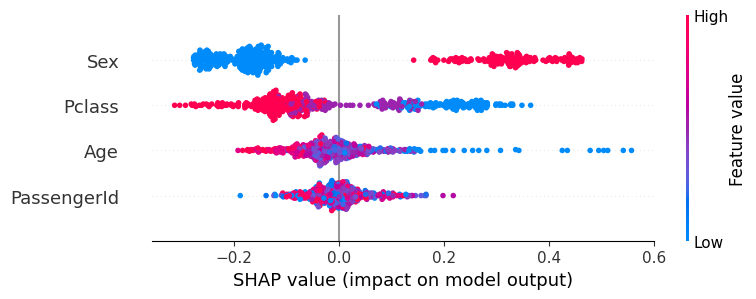

In [65]:
# Create SHAP summary plot
shap.summary_plot(shap_vals_rf_raw, X_train, X_train.columns, show=False)

### Compute smooth SHAP values

In order to calculate smooth SHAP values we need the inbag an OOB shap values. In order to get these you need to instantiate the RF model with `oob_SHAP=True`

In [66]:
# Fit regular RF model with oob_SHAP=True
rf = RandomForest(n_trees=100, treetype='classification', oob_SHAP=True, random_state=42)
rf.fit(X_train, y_train)

In [67]:
# The inbag and oob SHAP values are stored as class attributes of the RF model object
rf.inbag_SHAP_values # Inbag SHAP values
rf.oob_SHAP_values # OOB SHAP values

array([[-0.02159054, -0.07094237, -0.19103283, -0.06940424],
       [ 0.12524321,  0.09306224,  0.32191429, -0.04829458],
       [ 0.03781554, -0.0807783 , -0.15097095, -0.01945284],
       ...,
       [-0.00772972,  0.24817447,  0.34618808,  0.01056329],
       [-0.03057773, -0.14714212, -0.11871147, -0.0035749 ],
       [-0.00592465, -0.07220626, -0.16254208,  0.03937141]])

In [68]:
# Compute smooth SHAP values
smshap_vals, abs_mean_smshap, coefs_smshap = smooth_shap(rf.inbag_SHAP_values, rf.oob_SHAP_values)

In [ ]:
# Smooth SHAP coefficient for each feature
pd.DataFrame(np.array([coefs_smshap]), columns=X_train.columns)

,Age,Pclass,Sex,PassengerId
0,0.61567,0.923729,0.983575,0.102725
